In [1]:
import sys
import os
to_add = os.getcwd().split('/scripts')[0]
if not to_add in sys.path:
    sys.path.insert(0, to_add)

import diff_classifier.aws as aws
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import leastsq
from scipy.stats import sem
import ferretfit.ferretfit as ff

# Example use of ferret_fit

Video to analyze: F10_T1_R1_RF.csv
Deviation from midline: 23.92
Range in y: 62.5
Percent deviation from midline: 34.0
Fit amplitude: 46.88
Number of intersections: 8
Number of intersections per 100 pixels: 1.0
Number of footprints: 8
Number of footprints per 100 pixels: 1.0
Average stride: 82.0
Stride deviation: 29.0
Fit period: 40.79



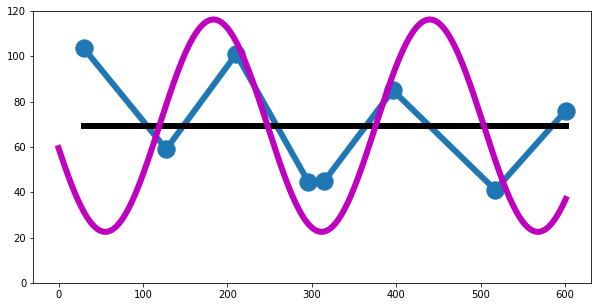

In [2]:
prefix = 'F10_T1_R1'
folder = 'ferret_tracking/09_17_18_redo'
test = ff.ferret_fit_color(folder, prefix)

# Example code to loop over multiple tracks

In [3]:
#This cell creates a list of csv names over which we will loop

s3 = boto3.resource('s3')
my_bucket = s3.Bucket('ccurtis.data')

all_files = []
for object_summary in my_bucket.objects.filter(Prefix=folder):
    all_files.append(object_summary.key)
    
all_csvs = []
for num in all_files:
    if 'csv' in num:
        all_csvs.append(num.split('/')[2].split('.')[0])

In [ ]:
all_csvs[0:-3]

Video to analyze: F10_T1_R1_LF.csv
Deviation from midline: 14.62
Range in y: 44.55
Percent deviation from midline: 15.0
Fit amplitude: 33.41
Number of intersections: 3
Number of intersections per 100 pixels: 1.0
Number of footprints: 8
Number of footprints per 100 pixels: 1.0
Average stride: 85.0
Stride deviation: 72.0
Fit period: 42.4



AttributeError: 'Bunch' object has no attribute 'yrangefoot'

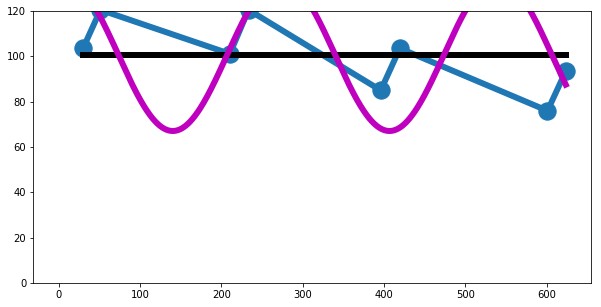

In [4]:
#And this cell does the brunt of the work.

d = {'deviation': [], 'range': [], 'rsd': [], 'amplitude': [], 'period': []}
df = pd.DataFrame(data=d)

for prefix in all_csvs:

    fparams = ff.ferret_fit(folder, prefix)
    df = df.append({'deviation':fparams.ystd, 'range':fparams.yrange, 'rsd':fparams.rsd, 'amplitude':fparams.amp,
                    'pawcount':fparams.pawcount, 'pawdensity':fparams.pawdens, 'period':fparams.period,
                    'cross':fparams.cross, 'crossdensity':fparams.crossdens, 'stride':fparams.stride,
                    'stridestd':fparams.stridestd, 'run':prefix,
                    'LH range': fparams.yrangefoot['LH'], 'LH std': fparams.ystdfoot['LH'], 'LH rsd': fparams.yrsdfoot['LH'],
                    'RH range': fparams.yrangefoot['RH'], 'RH std': fparams.ystdfoot['RH'], 'LH rsd': fparams.yrsdfoot['RH'],
                    'LF range': fparams.yrangefoot['LF'], 'LF std': fparams.ystdfoot['LF'], 'LH rsd': fparams.yrsdfoot['LF'],
                    'RF range': fparams.yrangefoot['RF'], 'RF std': fparams.ystdfoot['RF'], 'LH rsd': fparams.yrsdfoot['RF']},
                    ignore_index=True)

In [ ]:
fparams.ystd

In [ ]:
#This cell allows the user to perform averages of a parameter of interest after analysis and compare groups.

measure = 'period'

print('Mean wonky {}: {} +/- {}'.format(measure, np.average(df[0:15][measure]), sem(df[0:15][measure])))
print('Mean normal {}: {} +/- {}'.format(measure, np.average(df[15:30][measure]), sem(df[15:30][measure])))

np.average(df[0:15]['period'])

In [ ]:
#This cell saves the analyzed data to a csv file.
#df.to_csv('ferret_stats.csv')

stats = 'ferret_stats.csv'
#aws.upload_s3(stats, '{}/{}'.format(folder, stats), bucket_name='ccurtis.data')
aws.download_s3('{}/{}'.format(folder, stats), stats, bucket_name='ccurtis.data')

In [ ]:
df = pd.read_csv(stats, index_col='Unnamed: 0')

In [ ]:
df